##V2 2D NCA##
2/27/24

Imports:

In [1]:
# Imports for loading / displaying image
import io
import PIL.Image, PIL.ImageDraw
import requests
from IPython.display import Image, HTML, clear_output

# Standard imports
import numpy as np
import random
from tqdm.auto import tqdm

# TF / Keras
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D
from keras.layers import DepthwiseConv2D
from keras.layers import concatenate
from keras import Model
from keras import Input

Set the target emoji and parameters:

In [2]:
# First select the target emoji (any Google emoji)
target_emoji = "🦎"
code = hex(ord(target_emoji))[2:].lower()
target_url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code

image_size = 72
target_size = 40
target_padding = (image_size - target_size) // 2

# num_channels is the vector length in each cell
num_channels = 16

Load and display functions:

In [3]:
def load_image(url, max_size = target_size):
  """load_image loads an image and pixelizes it

  Args:
    url of the image and the target size to return
  Returns:
    a normalized np array with values between 0 - 1 that stores the image data
  """
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img) / 255.0
  img[..., :3] *= img[..., 3:4]
  return img

def load_emoji(emoji):
  """load_emoji calls load_image on a passed in emoji

  Args:
    a string that contains a Google emoji
  Returns:
    a normalized np array that stores the emoji data
  """
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
  return load_image(url)

def to_rgb(x):
  """Converts an image with RGB values multiplied by alpha to standard RGB format.

  Args:
      x: A NumPy array representing the image with premultiplied RGBA.
  Returns:
      A NumPy array representing the image in RGB format.
  """
  rgb, a = x[..., :3], x[...,3:4]
  return 1.0 - a + rgb

def np2pil(a):
  """Converts a NumPy array to a PIL image.

  Args:
      a: The NumPy array representing the image data.
  Returns:
      A PIL Image object.
  """
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1) * 255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  """Saves a NumPy array as an image file.

  Args:
      f: File object or filename to save the image to.
      a: NumPy array representing image data.
      fmt: Optional. Specifies the desired output format.
  """
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  """Encodes a NumPy array into a image format in memory, represented as bytes.

  Args:
      a: NumPy array representing the image data.
      fmt: Specifies the image format (default 'jpeg').
  Returns:
      Bytes object containing the encoded image.
  """
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def imshow(a, fmt='jpeg'):
  """Displays a NumPy array as an image.

  Args:
      a: NumPy array representing the image data.
      fmt: Specifies the image format (default 'jpeg').
  """
  display(Image(data = imencode(a, fmt)))

def zoom(img, scale=4):
  """Zooms an image by a specified scale factor, repeating pixels for enlargement.

  Args:
      img: The NumPy array representing the image to zoom.
      scale: The zoom factor (default 4).
  Returns:
      A NumPy array representing the zoomed image.
  """
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

Display the target image

<ipython-input-3-355ffec53c22>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)


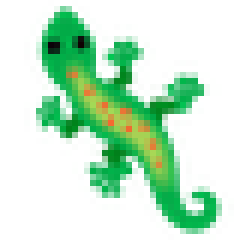

In [4]:
target_img = load_image(target_url, target_size)
imshow(zoom(to_rgb(target_img), 6), fmt = 'png')

We use MSE as our loss function

In [5]:
def calc_loss(y_true, y_pred):
  """MSE between the first 4 channels of the current and target state

  Args:
    y_true, y_pred: TF tensors that contain the RGBA channel values for each pixel
  Returns:
    MSE Loss
  """
  loss = tf.reduce_mean(tf.square(y_true[..., :4] - y_pred[..., :4]))
  return loss

In [6]:
class CA():

  def __init__(self, target_img, seed_type = 'seed'):
    print("Seed and target initialized")
    self.update_count = 0
    self.padded_target = self.pad_target(target_img)
    self.model = model_step
    self.opt = opt
    self.seed_type = seed_type
    self.set_seed()
    # dummy evaluation so model is completely initialized
    self.apply_model_step(self.state_grid)

  def set_seed(self):
    """initializes what starting seed to grow from. Defaults to 'seed'.
    The lizard model can also be initialized with 'diagonal' for quicker training.
    """
    self.state_grid = np.zeros((1, image_size, image_size, num_channels), np.float32)
    if self.seed_type == 'seed':
      self.state_grid[0, image_size // 2, image_size // 2, 3:] = 1
    elif self.seed_type == 'diagonal':
      # lizard has values for columns from 16 to 55
      y_indices = np.arange(26, 46)
      x_indices = 26 + np.arange(len(y_indices))
      for i in range(3, num_channels):
        self.state_grid[0, y_indices, x_indices, i] = 1

  def pad_target(self, target):
    p = target_padding
    padded = np.pad(target, [(p,p), (p,p), (0,0)])
    return np.array([padded])

  @tf.function
  def get_living_mask(self, x):
    """Determines living state of a cell given state of neighbors

    Args:
      x: the current state for all the cells
    Returns:
      boolean array indicating if a cell should be considered alive or dead
    """
    alpha = x[:, :, :, 3:4]
    return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

  def display_current_state(self, current_grid):
    imshow(zoom(to_rgb(current_grid[0]), 6), fmt = 'png')

  def grow(self, nsteps):
    """Display growth from seed to target

    Args:
      nsteps: grow for this many steps
    """
    self.set_seed()
    x = self.state_grid
    step = 1
    self.display_current_state(x)
    for i in range(nsteps):
      print("Time step ", step)
      x = self.apply_model_step(x)
      self.display_current_state(x)
      step += 1
    loss = tf.reduce_mean(calc_loss(self.padded_target, x))
    print("Current Loss: ", tf.get_static_value(loss))

  @tf.function
  def apply_model_step(self, input_img):
    """apply_model_step takes one time step forward in the RNN by calling the
     Sobel filters and passes the concatenated output into the Conv2D layers.
     The delta produced by the model is added to the state_grid if that specific
     cell is alive both before and after the update.

    Args:
      input_img: current state of the grid
    Returns:
      The updated state_grid
    """
    alive_before_update = self.get_living_mask(input_img)
    delta = self.model(input_img)
    new_img = input_img + delta
    still_living = self.get_living_mask(new_img)
    live = tf.cast(alive_before_update&still_living, tf.float32)
    return new_img * live

  @tf.function
  def train_step(self, input_img):
    """train_step calculates the gradients for an RNN of length RNN_length.
    train_step is called by train to be repeated ntimes. tf.Gradient tape watches all the weights
    and treats them as variables for backpropagation. g.gradient calculates the gradient vectors after
    the end of the RNN loop. The gradients are then normalized before the weights are updated.

    Args:
      input_img: current state of the grid
    Returns:
      The new state_grid and the loss
    """
    RNN_length = 100
    x = input_img
    with tf.GradientTape() as g:
      for i in range(RNN_length):
        x = self.apply_model_step(x)
      loss = calc_loss(self.padded_target, x)
    grads = g.gradient(loss, self.model.trainable_weights)
    grads = [grad / (tf.norm(grad) + 1e-8) for grad in grads]
    self.opt.apply_gradients(zip(grads, self.model.trainable_weights))
    return x, loss

  def train(self, ntimes):
    """trains an emoji model's weights ntimes by calling train_step on the starting seed.
    Displays the current training step, loss, and training time.

    Args:
      ntimes: trains the model n times
    """
    print("Training Steps Completed: " + str(self.update_count))
    for i in tqdm(range(ntimes)):
      self.set_seed()
      new_grid,loss = self.train_step(self.state_grid)
      self.update_count += 1
      self.state_grid = new_grid
      print("Training Steps Completed: " + str(self.update_count))
      print("Loss:"), tf.print(loss)
      self.display_current_state(self.state_grid)
    return

1. Create new model:

In [7]:
from keras.optimizers.schedules import PiecewiseConstantDecay
from keras.optimizers.schedules import ExponentialDecay

# Sobel filters in x direction

sobelx_kernel = np.zeros((3,3, num_channels))

for i in range(num_channels):
  sobelx_kernel[:,:,i] = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])

sobelx_kernel = sobelx_kernel.reshape((3, 3, num_channels, 1))

def Sobelx_init(shape, dtype=None):
  return sobelx_kernel

Sobelx_layer = DepthwiseConv2D(kernel_size = 3, depthwise_initializer = Sobelx_init, use_bias = False, padding = "same")
Sobelx_layer.trainable = False

# Sobel filters in y direction

sobely_kernel = np.zeros((3,3, num_channels))

for i in range(num_channels):
  sobely_kernel[:,:,i] = np.array([[-1,0,1], [-2,0,2], [-1,0,1]]).T

sobely_kernel = sobely_kernel.reshape((3, 3, num_channels, 1))

def Sobely_init(shape, dtype=None):
  return sobely_kernel

Sobely_layer = DepthwiseConv2D(kernel_size = 3, depthwise_initializer = Sobely_init, use_bias = False, padding = "same")
Sobely_layer.trainable = False

# Model concatenates output of sobel layers with the current state and passes through two Conv2D layers

image = Input(shape = (image_size, image_size, num_channels))
Sobel_x = Sobelx_layer(image)
Sobel_y = Sobely_layer(image)
concat = concatenate([Sobel_x, Sobel_y, image])
print(concat.shape)
dense1 = Conv2D(128, 3, activation = 'relu', bias_initializer = 'zeros', padding = 'same')(concat)
dense2=Conv2D(16, 1, activation = None, kernel_initializer = 'zeros', bias_initializer = 'zeros')(dense1)
model_step = Model(image, dense2)
model_step.summary()

lr = 1e-3
lr_sched = tf.keras.optimizers.schedules.ExponentialDecay(lr, 100, 0.9)
#lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2000], [lr,lr*.01])
opt = tf.keras.optimizers.Adam(lr_sched)

(None, 72, 72, 48)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 72, 72, 16)]         0         []                            
                                                                                                  
 depthwise_conv2d (Depthwis  (None, 72, 72, 16)           144       ['input_1[0][0]']             
 eConv2D)                                                                                         
                                                                                                  
 depthwise_conv2d_1 (Depthw  (None, 72, 72, 16)           144       ['input_1[0][0]']             
 iseConv2D)                                                                                       
                                                                           

Visualize model:

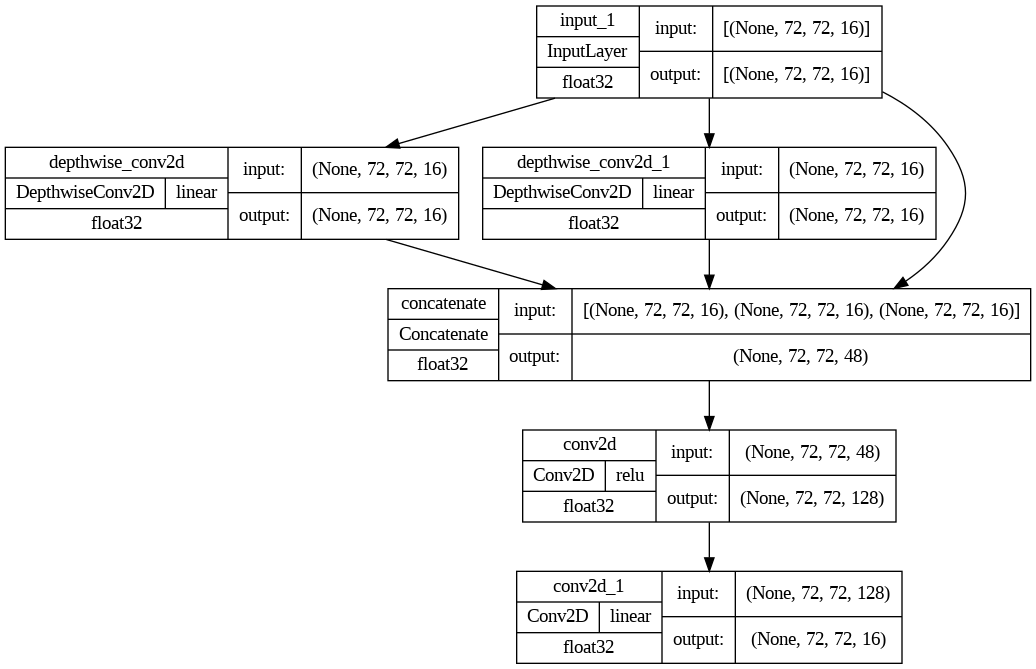

In [8]:
keras.utils.plot_model(model_step,show_shapes=True,show_dtype=True,show_layer_activations=True)

2. Initialize:

In [9]:
grid = CA(target_img)

Seed and target initialized


3. Train:

In [ ]:
grid.train(400)

Watch it grow for n steps:<br>(If you use a number > 100, you will see the instability when it grows past the number of steps it was trained for)

In [ ]:
grid.grow(100)

To save weights:

In [ ]:
model_step.save_weights('put name here.h5')

To load past weights:<br>
Click the folder icon and upload the weights file to colab. Insert the path below.

In [ ]:
grid = CA(target_img)
model_step.load_weights('/content/lizard_500.h5') # <- put your path here

In [ ]:
grid.grow(100)